 <font size="6"> <center> **[Open in Github](https://github.com/danielalcalde/apalis/blob/master/timings.ipynb)**</center></font> 

# Timings

## Apalis vs Ray

In this notebook, the overhead of both the libraries' Ray and Apalis is measured. For Apalis also its different syntaxes are compared in the next section. We conclude that for parallel workloads of more than **10ms** ray and Apalis perform similarly but under that Apalis outperforms ray.

In [1]:
import apalis
import ray
import timeit
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from collections import defaultdict

In [2]:
num_cpus = 16
ray.init(num_cpus=num_cpus);

2020-08-26 17:22:17,482	INFO resource_spec.py:212 -- Starting Ray with 35.25 GiB memory available for workers and up to 17.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-26 17:22:17,708	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-26 17:22:17,949	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


In [3]:
class A:
    def function(self, n):
        cum = 0
        for i in range(n):
            cum += i
        return cum

Ar = ray.remote(A)

In [4]:
obj_number = 16
objs = [A() for _ in range(obj_number)]

objs_apalis = [apalis.Handler(a) for a in objs]
objs_apalis_G = apalis.GroupHandler(objs, threads=num_cpus)
objs_ray = [Ar.remote() for _ in range(obj_number)]

Ray:

In [5]:
%%time
tokens = [obj.function.remote(1) for obj in objs_ray]
print(ray.get(tokens))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 16.6 ms


Apalis:

In [6]:
%%time
tokens = [obj.function(1) for obj in objs_apalis]
print(apalis.get(tokens))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.23 ms


All the functions that will be tested:

In [7]:
funcs = dict()

funcs["single"] = lambda x: [obj.function(x) for obj in objs]
funcs["ray"] = lambda x: ray.get([obj.function.remote(x) for obj in objs_ray])
funcs["apalis"] = lambda x: apalis.get([obj.function(x) for obj in objs_apalis])

Testing:

In [8]:
repeat = 50

Ns = np.asarray(np.logspace(2, 7, 20), dtype="int")

ts = defaultdict(lambda: np.zeros((len(Ns), repeat)))

for r in range(repeat):
    for i, n in enumerate(Ns):
        for j, (label, func) in enumerate(funcs.items()):
            number = max(1, 2 * 10 ** 4 // n)

            t = timeit.timeit(lambda : func(n), number=number)
            ts[label][i][r] =  t / number

ts_std = defaultdict(lambda: np.zeros(len(Ns)))
for label in ts:
    ts_std[label] = ts[label].std(axis=1) / np.sqrt(repeat)
    ts[label] = ts[label].mean(axis=1)

Apalis vs Ray timings:

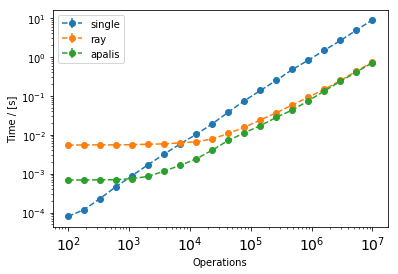

In [9]:
plt.ylabel("Time / [s]")
plt.xlabel("Operations")

for label in ["single", "ray", "apalis"]:
    plt.errorbar(Ns, ts[label], yerr=ts_std[label], fmt="--o", label=label)

plt.xscale("log")
plt.yscale("log")

plt.xticks(fontsize=14)
plt.legend()
plt.show()

The improvement over single-threaded vs the time it takes the function to execute in single-threaded:

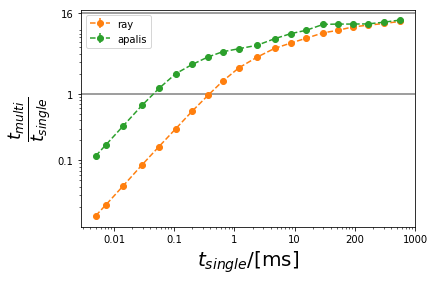

In [12]:
ax = plt.gca()

plt.ylabel(r"$\frac{t_{multi}}{t_{single}}$", size=25)
plt.xlabel("$t_{single}$/[ms]", size=20)
plt.plot([],[])

for label in ["ray", "apalis"]:
    error = ts_std["single"] / ts[label] + ts["single"] * ts_std[label] / ts[label] ** 2
    plt.errorbar(ts["single"] * 1000 / num_cpus, ts["single"] / ts[label], yerr=error, fmt="--o", label=label)

plt.xscale("log")
plt.yscale("log")

plt.axhline(1, color="gray")
plt.axhline(num_cpus, color="gray")

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

ax.set_xticks([0.01, 0.1, 1, 10, 100, 1000])
ax.set_xticklabels(["0.01", "0.1", "1", "10", "200", "1000"])

ax.set_yticks([0.1, 1, 16])
ax.set_yticklabels(["0.1", "1", "16"])

plt.legend()
plt.show()

Note that the longer the task takes the closer to 16 times improvement we come.

## Performance of the different apalis syntaxes

The GroupHandler handles several objects at a time. It should be used instead of Handler if the amount of objects that need to be parallelized is larger than the number of cores. Here we compare for the case where we want to parallelize 32 objects on 16 cores.

In [13]:
obj_number = 32
objs = [A() for _ in range(obj_number)]

objs_apalis = [apalis.Handler(a) for a in objs]
objs_apalis_G = apalis.GroupHandler(objs, threads=num_cpus)

Handler:

In [14]:
%%time
tokens = [obj.function(1) for obj in objs_apalis]
print(apalis.get(tokens))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 8.91 ms


Group Handler:

In [15]:
%%time
tasks = [obj.function(1) for obj in objs_apalis_G]
print(objs_apalis_G.multiple_run(tasks)())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.48 ms


Faster but more cumbersome syntax:

In [16]:
%%time
tasks = [{"i": i, "mode": "run", "name": "function", "args": (1,)} for i in range(obj_number)]
print(objs_apalis_G.multiple_run(tasks)())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.2 ms


Runs the tasks and directly returns the outputs. Does not need to deal with the overhead of creating Tokens.

In [17]:
%%time
tasks = [{"i": i, "mode": "run", "name": "function", "args": (1,)} for i in range(obj_number)]
print(objs_apalis_G.run(tasks))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.84 ms


Timing for different parallelization solutions:

In [18]:
funcsA = dict()

funcsA["single"] = lambda x: [obj.function(x) for obj in objs]
funcsA["handler"] = lambda x: apalis.get([obj.function(x) for obj in objs_apalis])
funcsA["group handler"] = lambda x: objs_apalis_G.multiple_run([obj.function(x) for obj in objs_apalis_G])()
funcsA["run"] = lambda x: objs_apalis_G.run([{"i": i, "mode": "run", "name": "function", "args": (x,)} for i in range(obj_number)])
funcsA["fast syntax"] = lambda x: objs_apalis_G.multiple_run([{"i": i, "mode": "run", "name": "function", "args": (x,)} for i in range(obj_number)])()

Testing:

In [21]:
repeat = 50

Ns = np.asarray(np.logspace(2, 7, 20), dtype="int")

tsA = defaultdict(lambda: np.zeros((len(Ns), repeat)))

for r in range(repeat):
    for i, n in enumerate(Ns):
        for j, (label, func) in enumerate(funcsA.items()):
            number = max(1, 2 * 10 ** 4 // n)

            t = timeit.timeit(lambda : func(n), number=number)
            tsA[label][i][r] =  t / number

ts_stdA = defaultdict(lambda: np.zeros(len(Ns)))
for label in tsA:
    ts_stdA[label] = tsA[label].std(axis=1) / np.sqrt(repeat)
    tsA[label] = tsA[label].mean(axis=1)

Plotting:

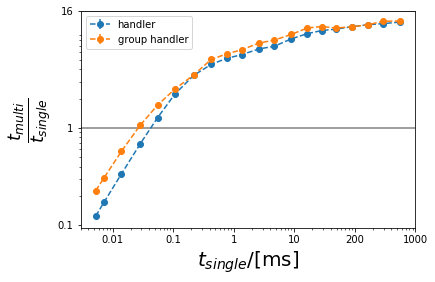

In [22]:
ax = plt.gca()

plt.ylabel(r"$\frac{t_{multi}}{t_{single}}$", size=25)
plt.xlabel("$t_{single}$/[ms]", size=20)

for label in ["handler", "group handler"]:
    error = ts_stdA["single"] / tsA[label] + tsA["single"] * ts_stdA[label] / tsA[label] ** 2
    plt.errorbar(tsA["single"] * 1000 / obj_number, tsA["single"] / tsA[label], yerr=error, fmt="--o", label=label)

plt.xscale("log")
plt.yscale("log")

plt.axhline(1, color="gray")
plt.axhline(num_cpus, color="gray") 

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

ax.set_xticks([0.01, 0.1, 1, 10, 100, 1000])
ax.set_xticklabels(["0.01", "0.1", "1", "10", "200", "1000"])

ax.set_yticks([0.1, 1, 16])
ax.set_yticklabels(["0.1", "1", "16"])

plt.legend()
plt.show()

Percentage improvement of run vs the other methods:

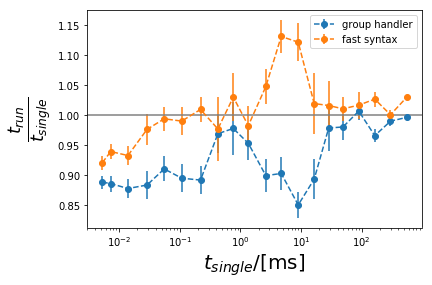

In [23]:
plt.ylabel(r"$\frac{t_{run}}{t_{single}}$", size=25)
plt.xlabel("$t_{single}$/[ms]", size=20)

for label in ["group handler", "fast syntax"]:
    error = ts_stdA["run"] / tsA[label] + tsA["run"] * ts_stdA[label]  / tsA[label] ** 2
    plt.errorbar(tsA["single"] * 1000 / obj_number, tsA["run"] / tsA[label], yerr=error, fmt="--o", label=label)

plt.xscale("log")
    
plt.axhline(1, color="gray")
plt.legend()
plt.show()